In [27]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import pyautogui
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from datetime import datetime
import requests

In [28]:
def scrape_stock_list(url="https://www.infomoney.com.br/cotacoes/empresas-b3/"):
    """
    Retrieves stock information from the given URL.

    Parameters:
        url (str, optional): The URL to fetch stock information from. Defaults to
                            "https://www.infomoney.com.br/cotacoes/empresas-b3/".

    Returns:
        dict: A dictionary containing stock information with keys 'stock', 'value','type', and 'link'.

    The function fetches stock information from the specified webpage, including
    stock names, values, types, and links. It returns the data in a dictionary format.

    Example:
        stock_data = get_stock_list()
        print(stock_data)
    """
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    stocks = []
    values = []
    links = []
    types = []

    tables = soup.find_all('table')

    # Iterate through each table
    for table in tables:
        # Find all rows (tr) in the table
        rows = table.find_all('tr')

        # Iterate through each row
        for row in rows:
            # Find the <td class='higher'> containing the name of the stock
            stock_name_td = row.find('td', class_='higher')
            if stock_name_td:
                stock_name = stock_name_td.text.strip()

                # Find all <td class='strong'> containing <a> tags with links and values
                strong_tds = row.find_all('td', class_='strong')
                for strong_td in strong_tds:
                    link_a = strong_td.find('a')
                    if link_a:
                        link = link_a['href']
                        value = link_a.text.strip()

                        # Extract the 'type' from the link
                        type_start = link.find('/b3/') + 4
                        type_end = link.find('/', type_start)
                        asset_type = link[type_start:type_end]

                        # Append data to lists
                        stocks.append(stock_name)
                        values.append(value)
                        links.append(link)
                        types.append(asset_type)

    # Create a DataFrame
    return {'stock': stocks, 'value': values, 'type': types, 'link': links}

In [29]:
df_stocks = pd.DataFrame(scrape_stock_list())
df_stocks.head()

,stock,value,type,link
0,Grupo Casas Bahia,BHIA3,acao,https://www.infomoney.com.br/cotacoes/b3/acao/...
1,Riza Arctium Real Estate FII Closed Fund,RZAT11,fii,https://www.infomoney.com.br/cotacoes/b3/fii/r...
2,Fiagro Greenwich Fundo de Investimento nas Cad...,GRWA11,fii,https://www.infomoney.com.br/cotacoes/b3/fii/f...
3,Sparta Fiagro Fundo de Investimento Cadeias Pr...,CRAA11,fii,https://www.infomoney.com.br/cotacoes/b3/fii/s...
4,ZAMP S.A.,ZAMP3,acao,https://www.infomoney.com.br/cotacoes/b3/acao/...


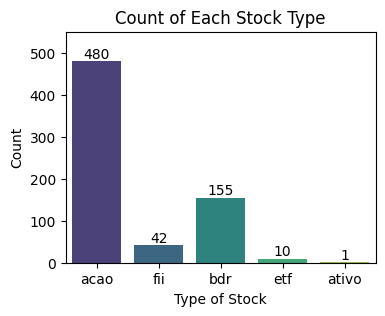

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar um gráfico de barras usando seaborn
fig = plt.figure(figsize=(4, 3))
ax = sns.countplot(x='type', data=df_stocks, palette='viridis')
plt.xlabel('Type of Stock')
plt.ylabel('Count')
plt.title('Count of Each Stock Type')
plt.ylim(top=550)
# Adicionar a quantidade acima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

In [31]:
def click_on_element(driver, method, path, wait_time=30):
    try:
        WebDriverWait(driver, wait_time).until(EC.element_to_be_clickable((method, path))).click()
        return True
    except:
        print(f'Can not click on {path}')
        return False

In [32]:
def enter_text(driver, method, path, text):
    try:
        element_cnpj = driver.find_element(by=method, path=path)
        element_cnpj.send_keys(text)
    except:
        print('Could not enter text')

In [36]:
def get_stock_data(url, tipo, ativo):
    chrome_options = Options()
    chrome_options.add_argument('--headless')  # Run in headless mode
    driver = webdriver.Chrome()
    driver.get(url)
    # driver.maximize_window()

    #esperar entre 2 e 10 segundos para a pagina carregar
    time.sleep(random.uniform(2, 10))

    print('Switching to iFrame')
    driver.switch_to.frame(driver.find_element(By.TAG_NAME, "iframe"))

    click_on_element(driver=driver, method=By.XPATH, path='//*[@id="fechar"]')
    print('Click on close button')

    print('Switching to the main frame')
    driver.switch_to.default_content()

    click_on_element(driver=driver, method=By.XPATH, path='//*[@id="dateMin"]')
    pyautogui.hotkey('0', '1', '/', '0', '1', '/','2', '0','2', '0',interval=0.3)

    today = datetime.now().strftime("%d/%m/%Y").strip()
    click_on_element(driver=driver, method=By.XPATH, path='//*[@id="dateMax"]')
    pyautogui.hotkey(today[0], today[1], today[2], today[3], today[4], today[5], today[6], today[7], today[8], today[9],interval=0.3)

    click_on_element(driver=driver, method=By.XPATH, path='//*[@id="see_all_quotes_history"]')
    print('Clicked on see data')

    try:
        WebDriverWait(driver, 120).until(EC.visibility_of_all_elements_located((By.XPATH, '//*[@id="quotes_history"]/tbody')))
    except:
        print('Loading not completed')

    time.sleep(20)
    #obter o HTML da pagina
    html = driver.page_source

    #Fechar driver do chrome
    driver.quit()

    #Usar o BS4 para analisar o meu html da url
    soup = BeautifulSoup(html, 'html.parser')

    _ativo = []
    _tipo = []
    data = []
    abertura = []
    fechamento = []
    variacao = []
    minimo = []
    maximo = []
    volume = []

    # Encontrar todas as linhas <tr>
    rows = soup.find('table').find_all('tr')

    # Iterar sobre as linhas e extrair os valores
    for row in rows[1:]:
        _ativo.append(ativo)
        _tipo.append(tipo)
        for index, row_value in enumerate(row):
            # row_value.text.
            if index == 0:
                data.append(row_value.text)
            elif index == 1:
                abertura.append(row_value.text)
            elif index == 2:
                variacao.append(row_value.text)
            elif index == 3:
                fechamento.append(row_value.text)
            elif index == 4:
                minimo.append(row_value.text)
            elif index == 5:
                maximo.append(row_value.text)
            elif index == 6:
                volume.append(row_value.text)

    # Create a DataFrame
    return  {
                'ATIVO': _ativo,
                'TIPO': _tipo,
                'DATA': data, 
                'ABERTURA': abertura, 
                'FECHAMENTO': fechamento, 
                'VARIACAO': variacao,
                'MINIMO': minimo, 
                'MAXIMO': maximo, 
                'VOLUME': volume, 
            }


In [34]:
def loading_failed(data):
    for valor in data.values():
        if valor == 'Carregando...':
            return True
    return False
    

In [37]:
# Dicionário para armazenar os resultados
header_df = ['ATIVO', 'TIPO', 'DATA', 'ABERTURA', 'FECHAMENTO', 'VARIACAO', 'MINIMO', 'MAXIMO', 'VOLUME']
df_resultados = pd.DataFrame(columns=header_df)

for index, row in df_stocks[df_stocks['type']=='etf'].iterrows():
    link = row['link']
    tipo = row['type']
    ativo = row['value']

    for index in range(3):
        # Chamar o método de busca
        try:
            resultado = get_stock_data(f"{link}historico/", tipo, ativo)
        except:
            print("Falhoooou")
            resultado = 'Failed'

        if resultado == 'Failed':
            print('Loading failed')
            resultado = []
        else:
            # Adicionar os resultados ao dicionário
            df_resultados = pd.concat([df_resultados, pd.DataFrame.from_dict(resultado)], ignore_index=True)
            print(f"{ativo} carregado com sucesso!\n")
            break


Switching to iFrame
Click on close button
Switching to the main frame
Clicked on see data
FOOD11 carregado com sucesso!

Switching to iFrame
Click on close button
Switching to the main frame
Clicked on see data
NDIV11 carregado com sucesso!

Switching to iFrame
Click on close button
Switching to the main frame
Clicked on see data
ALUG11 carregado com sucesso!

Switching to iFrame
Click on close button
Switching to the main frame
Clicked on see data
WRLD11 carregado com sucesso!

Switching to iFrame
Click on close button
Switching to the main frame
Clicked on see data


ValueError: All arrays must be of the same length

In [ ]:
resultado

In [ ]:
df_resultados

,ATIVO,TIPO,DATA,ABERTURA,FECHAMENTO,VARIACAO,MINIMO,MAXIMO,VOLUME
0,FOOD11,etf,13/11/2023,"73,78","-0,04","74,03","73,78","74,03","442,93"
1,FOOD11,etf,10/11/2023,"73,46","-1,11","74,06","73,46","74,06","4,48K"
2,FOOD11,etf,09/11/2023,"74,47","-0,39","74,89","74,47","74,89","5,51K"
3,FOOD11,etf,08/11/2023,"75,18","5,01","75,18","75,18","75,18","75,18"
4,FOOD11,etf,07/11/2023,"73,98","-5,33","71,59","71,59","73,98","2,70K"
...,...,...,...,...,...,...,...,...,...
1357,WRLD11,etf,22/11/2021,"105,01","-0,23","104,14","103,61","105,89","928,59K"
1358,WRLD11,etf,19/11/2021,"104,00","0,20","104,38","103,09","104,66","402,64K"
1359,WRLD11,etf,18/11/2021,"103,30","0,99","104,17","103,15","104,50","239,21K"
1360,WRLD11,etf,17/11/2021,"103,80","0,00","103,15","102,54","103,87","1,38M"
